# 1. Noise-free data

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## 1.1

In [3]:
def simulate_sir_simple(lam, mu, I_0, T):
    """
    simulates the epidemy using the Euler forward scheme up to day T.
    lam = infection rate
    mu = recovery rate
    I_0 = initial percentage of infected people
    T = days to simulate
    """
    # Initialize variables
    S = 1.0 - I_0
    I = I_0
    R = 0.0
    
    # Lists to store observations and ODE variables
    X = np.zeros((T, 2))
    C = np.zeros((T, 3))
    
    for day in range(T):
        
        # Calculate new values using Euler forward scheme
        new_infections = lam * S * I
        dS = -new_infections
        dI = new_infections - mu * I
        dR = mu * I

        S += dS
        I += dI
        R += dR

        # Append current values to the lists
        X[day] = [dS,dR]
        C[day] = [S, I, R]

    
    return X, C


## 1.2

In [23]:
def plot_sir_simulation(C, title='SIR Model Simulation'):
    """
    Plots the SIR simulation results.

    C: Array containing the S, I, R values at each timestep
    T: Total number of days in the simulation
    """
    days = range(len(C))

    # Extract S, I, R values
    S, I, R = C[:,0], C[:,1], C[:,2]

    # Plotting
    plt.figure(figsize=(7, 4))
    plt.plot(days, S, label='Susceptible')
    plt.plot(days, I, label='Infected')
    plt.plot(days, R, label='Recovered')

    plt.xlabel('Days')
    plt.ylabel('Population Proportion')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

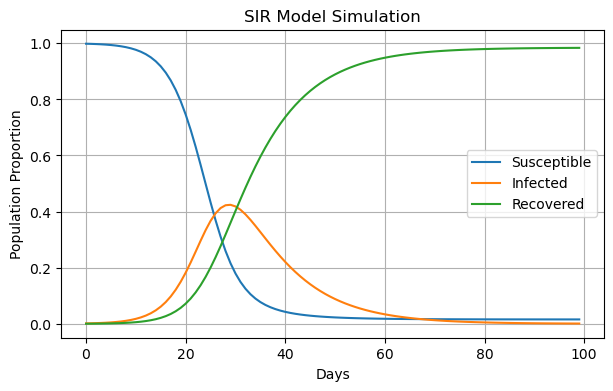

In [33]:
lambda_val = 0.4 
mu_val = 0.1     
initial_infected = 0.001  
num_days = 100 

X, C = simulate_sir_simple(lambda_val, mu_val, initial_infected, num_days)

plot_sir_simulation(C)

After some trial and error we found values $\lambda$ = 0.25, $\mu$ = 0.1, and $I_0$ = 0.001 that exhibit interesting and diverse dynamics. Now we look at the ranges of each value where we still see interesting dynamics

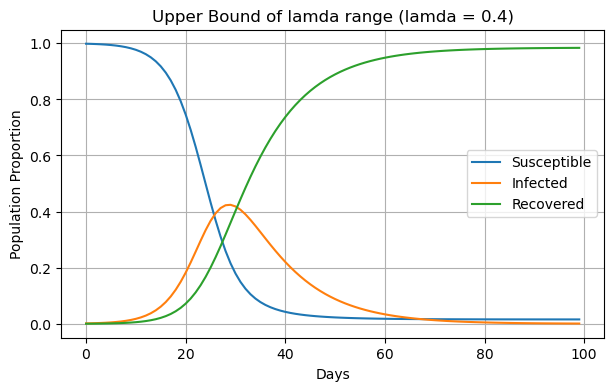

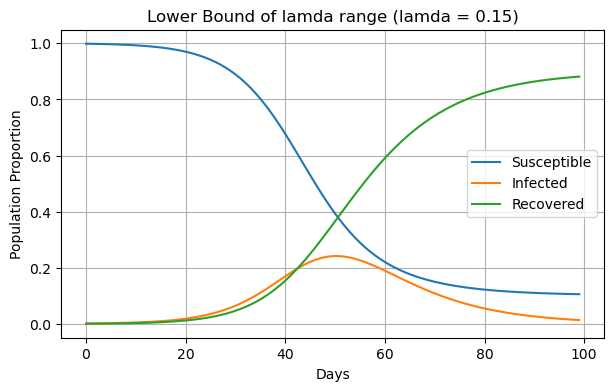

In [43]:
lambda_val_1 = 0.40
lambda_val_2 = 0.25

X_1, C_1 = simulate_sir_simple(lambda_val_1, mu_val, initial_infected, num_days)
X_2, C_2 = simulate_sir_simple(lambda_val_2, mu_val, initial_infected, num_days)

plot_sir_simulation(C_1, title="Upper Bound of lamda range (lamda = 0.4)")
plot_sir_simulation(C_2, title="Lower Bound of lamda range (lamda = 0.15)")

So lambda should be in the range between $\lambda = [0.25, 0.4]$. Lets do the same with $\mu$ and $I_0$

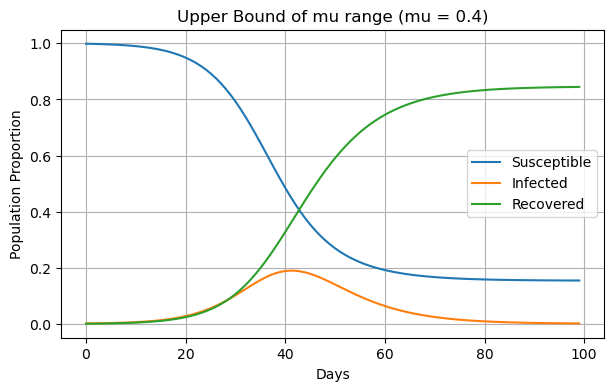

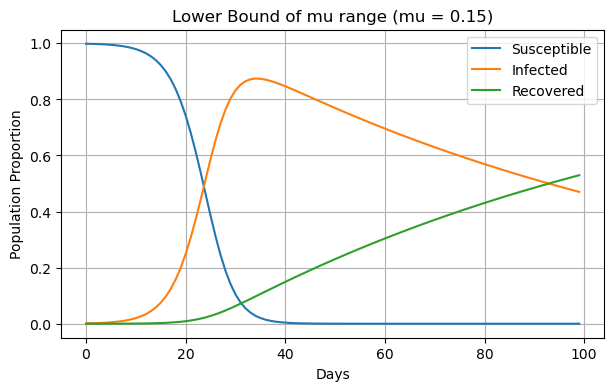

In [51]:
mu_val_1 = 0.15
mu_val_2 = 0.01
lambda_val = 0.325

X_1, C_1 = simulate_sir_simple(lambda_val, mu_val_1, initial_infected, num_days)
X_2, C_2 = simulate_sir_simple(lambda_val, mu_val_2, initial_infected, num_days)

plot_sir_simulation(C_1, title="Upper Bound of mu range (mu = 0.4)")
plot_sir_simulation(C_2, title="Lower Bound of mu range (mu = 0.15)")

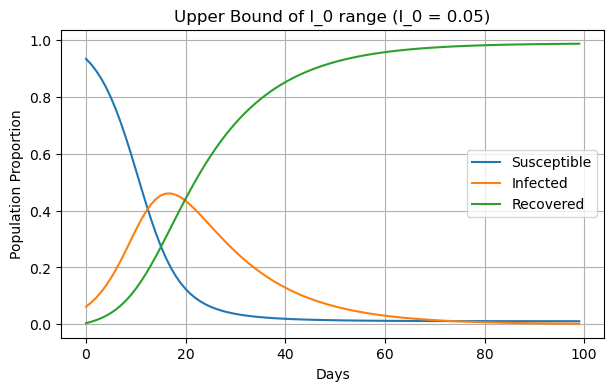

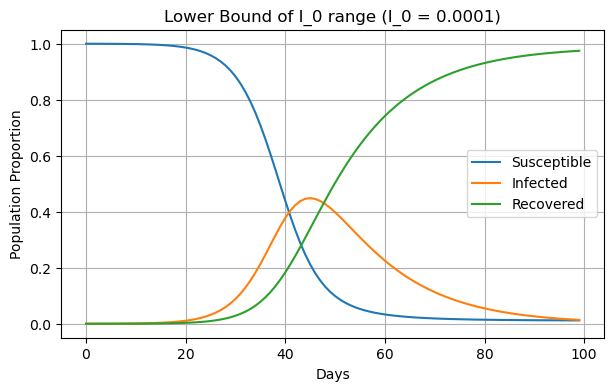

In [58]:
mu_val = 0.075
initial_infected_1 = 0.05  
initial_infected_2 = 0.0001  


X_1, C_1 = simulate_sir_simple(lambda_val, mu_val, initial_infected_1, num_days)
X_2, C_2 = simulate_sir_simple(lambda_val, mu_val, initial_infected_2, num_days)

plot_sir_simulation(C_1, title="Upper Bound of I_0 range (I_0 = 0.05)")
plot_sir_simulation(C_2, title="Lower Bound of I_0 range (I_0 = 0.0001)")

From our test we get suitable range of:   
$\lambda = [0.25, 0.4]$
$\mu = [0.01, 0.15]$
$I_0 = [0.0001, 0.05]$

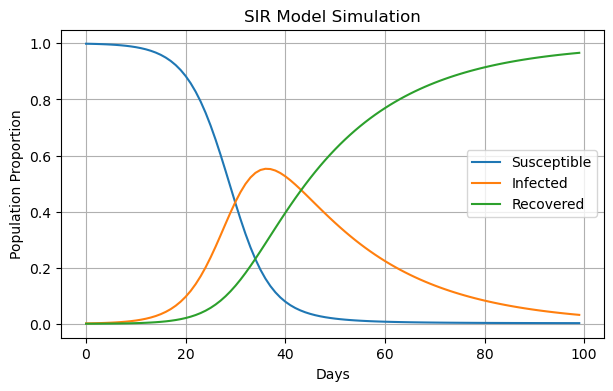

In [63]:
lambda_val = 0.3 
mu_val = 0.05     
initial_infected = 0.001  
num_days = 100 

X, C = simulate_sir_simple(lambda_val, mu_val, initial_infected, num_days)

plot_sir_simulation(C)

## 1.3

First, we define a dataset for training:

In [ ]:
class SIRDataset(Dataset):
    def __init__(self, size, T):
        self.size = size
        self.T = T
        self.data = []
        self.targets = []

        lam_prior = np.random.uniform(0.25, 0.4, size=size)  
        mu_prior = np.random.uniform(0.01, 0.15, size=size)  
        I_0_prior = np.random.uniform(0.0001, 0.05, size=size)
        
        for i in range(size):
            lam = lam_prior[i]
            mu = mu_prior[i]
            I_0 = I_0_prior[i]
            X, _ = simulate_sir_simple(lam, mu, I_0, T)
            self.data.append(X)
            self.targets.append([lam, mu, I_0])

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

Next, we define a network architecture and train it on our datasets

In [ ]:
class SIRNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SIRNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 3)  

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def train_network(net, train_loader, validation_loader, optimizer, criterion, epochs=5):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    for epoch in range(epochs):
        # Train:
        train_loss = 0
        net.train()
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() 
        
        # Validate: 
        net.eval()
        validation_loss = 0
        with torch.no_grad():
            for data, targets in validation_loader:
                outputs = net(data)
                loss = criterion(outputs, targets)
                validation_loss += loss.item()

        train_losses[epoch] = train_loss/len(train_loader)
        validation_losses[epoch] = validation_loss/len(validation_loader)

    return train_losses, validation_losses



In [ ]:
train_dataset = SIRDataset(size=1000, T=100)
validation_dataset = SIRDataset(size=200, T=100) 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)

net = SIRNet(input_size=100*2, hidden_size=50)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
train_network(net, train_loader,validation_loader, optimizer, criterion, 10)

# 2. Noisy data

# 3. Model misspecification detection

# 4. Sensitivity analysis